In [66]:
# !pip install wheel
# !pip install h5py
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [67]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib
import math
from heapq import merge
from math import floor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.multitest import multipletests
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

In [68]:
data

,kmers_enc,gene
0,"[-0.2465915365853658, -0.16277146341463414, -0...",VPS8
1,"[0.2118562739726028, -0.026304589041095894, -0...",SSA1
2,"[0.05899230817610064, 0.015229836477987405, -0...",ERP2
3,"[0.023513177419354835, -0.09981517741935486, 0...",FUN14
4,"[-0.2515238709677419, 0.001784112903225823, -0...",SPO7
...,...,...
4864,"[-0.0013235301204819088, 0.11704574698795173, ...",TKL1
4865,"[0.09345374666666667, -0.09823758666666661, 0....",MRL1
4866,"[0.08529584210526317, 0.3906876315789474, -0.0...",GRS2
4867,"[-0.12277170129870128, 0.056526298701298654, -...",MRI1


In [69]:
len(embedding_mat.tolist())

5002

In [70]:
len(genes)

4869

In [118]:
from math import floor, ceil
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    chunk_size = ceil(len(lst) / n)
    old = lst
    for i in np.linspace(0, len(lst), n,endpoint=False):
        i = round(i)
        part = lst[i:i + min(chunk_size, len(lst))]
        yield (part  if part else old) 
        if part:
            old = part

In [223]:
import pickle
with open('../processed_data/utrs_embeddings_6_10_50.pkl', 'rb') as inp:
    [genes, tokenized, embedding_keys, embedding_mat] = pickle.load(inp)

mat = np.array([np.mean([embedding_mat[i, :] for i in t],axis=0) for t in tokenized])
# extended_mat = np.array([np.hstack([
#         np.mean([embedding_mat[i, :] for i in t],axis=0) for t in chunks(tok, 2)]) for tok in tokenized])



In [224]:
data = pd.DataFrame({'kmers_enc': mat.tolist() , 'gene':genes})

In [225]:
with open('../processed_data/utrs_glove.pkl', 'wb') as out:
    pickle.dump(pd.DataFrame(mat).rename(columns={i:f'gl{i + 1}' for i in range(mat.shape[1])}).set_index(pd.Series(genes,name='gene')), out)

In [226]:
with open(f'../processed_data/utrs_glove_extended.pkl', 'wb') as out:
    pickle.dump(pd.DataFrame(extended_mat).rename(columns={i:f'gl{i + 1}' for i in range(extended_mat.shape[1])}).set_index(pd.Series(genes,name='gene')), out)

In [227]:
gloveUtrs = np.vstack(data['kmers_enc'])

In [228]:
np.isfinite(gloveUtrs).all()

True

Read Fluorescence information and apply necessary transformations (negative values removal, log, cutoff at -20)

In [229]:
fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
fDf.dropna(subset=['intensity'],inplace=True)
fDf.head()

,gene,systematicName,intensity
0,SSA1,YAL005C,11.906396
1,ERP2,YAL007C,0.299776
2,FUN14,YAL008W,0.455914
3,SPO7,YAL009W,0.027090
5,SWC3,YAL011W,0.031941


In [230]:
whole = data[['gene', 'kmers_enc']].merge(fDf[['gene','intensity']], on='gene', how='inner')
whole.head()

,gene,kmers_enc,intensity
0,SSA1,"[-0.013935753424657539, 0.112908, 0.0654456712...",11.906396
1,ERP2,"[-0.011414716981132066, 0.10064866037735848, 0...",0.299776
2,FUN14,"[-0.09860083870967742, 0.11696366129032261, 0....",0.455914
3,SPO7,"[0.09507661290322578, 0.24393953225806445, 0.1...",0.027090
4,SWC3,"[0.002400294117647079, 0.05632075, -0.19836926...",0.031941


In [231]:
i = whole['intensity'].copy()
mask = i > 0 # negative intensities make no sense
print(f"Removing {sum(~mask)} rows that have negative intensity")
clean = whole[mask].copy()
clean['logInt'] = np.log(clean['intensity'])
maskLog = clean['logInt']>-20
print(f"Removing {sum(~maskLog)} rows that have outliers log Intensity values <= -20")
clean = clean[clean['logInt']>-20]
x = np.vstack(clean['kmers_enc'])
y = clean['logInt'].copy()

Removing 106 rows that have negative intensity
Removing 6 rows that have outliers log Intensity values <= -20


Text(0.5, 0, 'log(FI)')

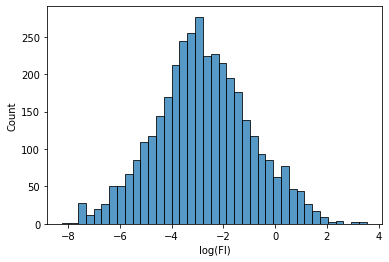

In [232]:
# QC of the transformed fluorescence values
sns.histplot(y)
plt.xlabel("log(FI)")

In [233]:
# Log frequency appears to follow a gaussian distribution, so it gets to be partitioned using sigmas
m = y.mean() 
s = y.std()
bins = [m - 2*s , m-s, m, m+s, m+2 *s]
groups = np.digitize(y, bins)
np.unique(groups)

array([0, 1, 2, 3, 4, 5])

Analyze the relationship between embeddings and logFI

In [234]:
x.shape

(3640, 50)

In [235]:
pcs = PCA(2).fit_transform(StandardScaler().fit_transform(x))

Text(0.5, 1.0, 'PCs of GLoVE embeddings')

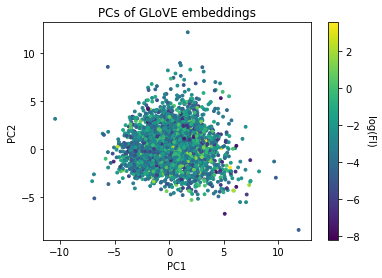

In [236]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=y, s=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(FI)', rotation=270)
plt.title("PCs of GLoVE embeddings")

In [249]:
## SelectKBest with f_regress 
featsSelector = SelectKBest(f_regression).fit(x,y)
pvals = featsSelector.pvalues_
qvals = multipletests(pvals, 0.1, method='fdr_bh')
numSig = sum(qvals[0])
maskSig = qvals[0]
order = np.argsort(qvals[1])
print("Significant # of embedding dimensions:", numSig)


Significant # of embedding dimensions: 23


In [255]:
sigEmbDf = pd.DataFrame({'emb': [f'gl{i}' for i in  range(len(pvals))], 'qval':qvals[1]})
sigEmbDf['log_qval'] = -np.log10(sigEmbDf.qval)
sigEmbDf.sort_values('qval',inplace=True)

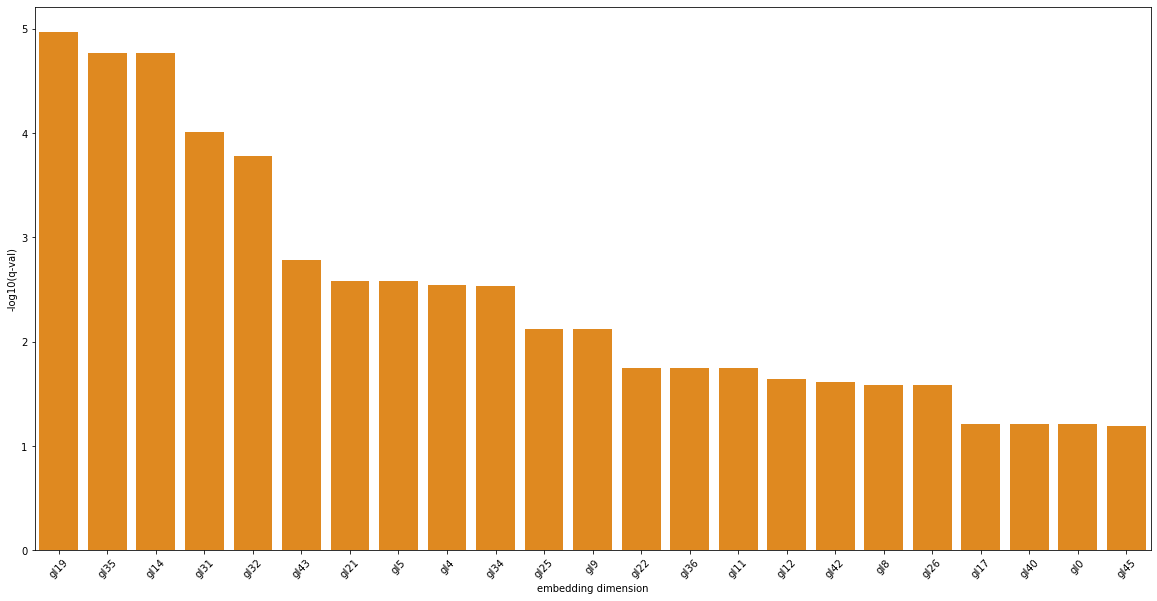

In [258]:
plt.figure(figsize=(20,10))
sns.barplot(data=sigEmbDf[sigEmbDf['qval']<0.1],  x='emb', y='log_qval',color='darkorange')
plt.xticks(rotation=45)
plt.ylabel('-log10(q-val)')
plt.xlabel("embedding dimension")
# _ = plt.title("Q-Value of motif presence effect on FI")
plt.savefig(f'../figures/f_score_glove_qvalues.png', dpi=100)

In [238]:
clean['gene'].values.shape

(3640,)

In [239]:
embsDF = pd.DataFrame(
    np.array(clean['kmers_enc']).tolist(), columns=[f'E{i}' for i in range(np.array(clean['kmers_enc'].iloc[0]).size)], index=clean['gene'].values)


Significant embedding dimensions histograms


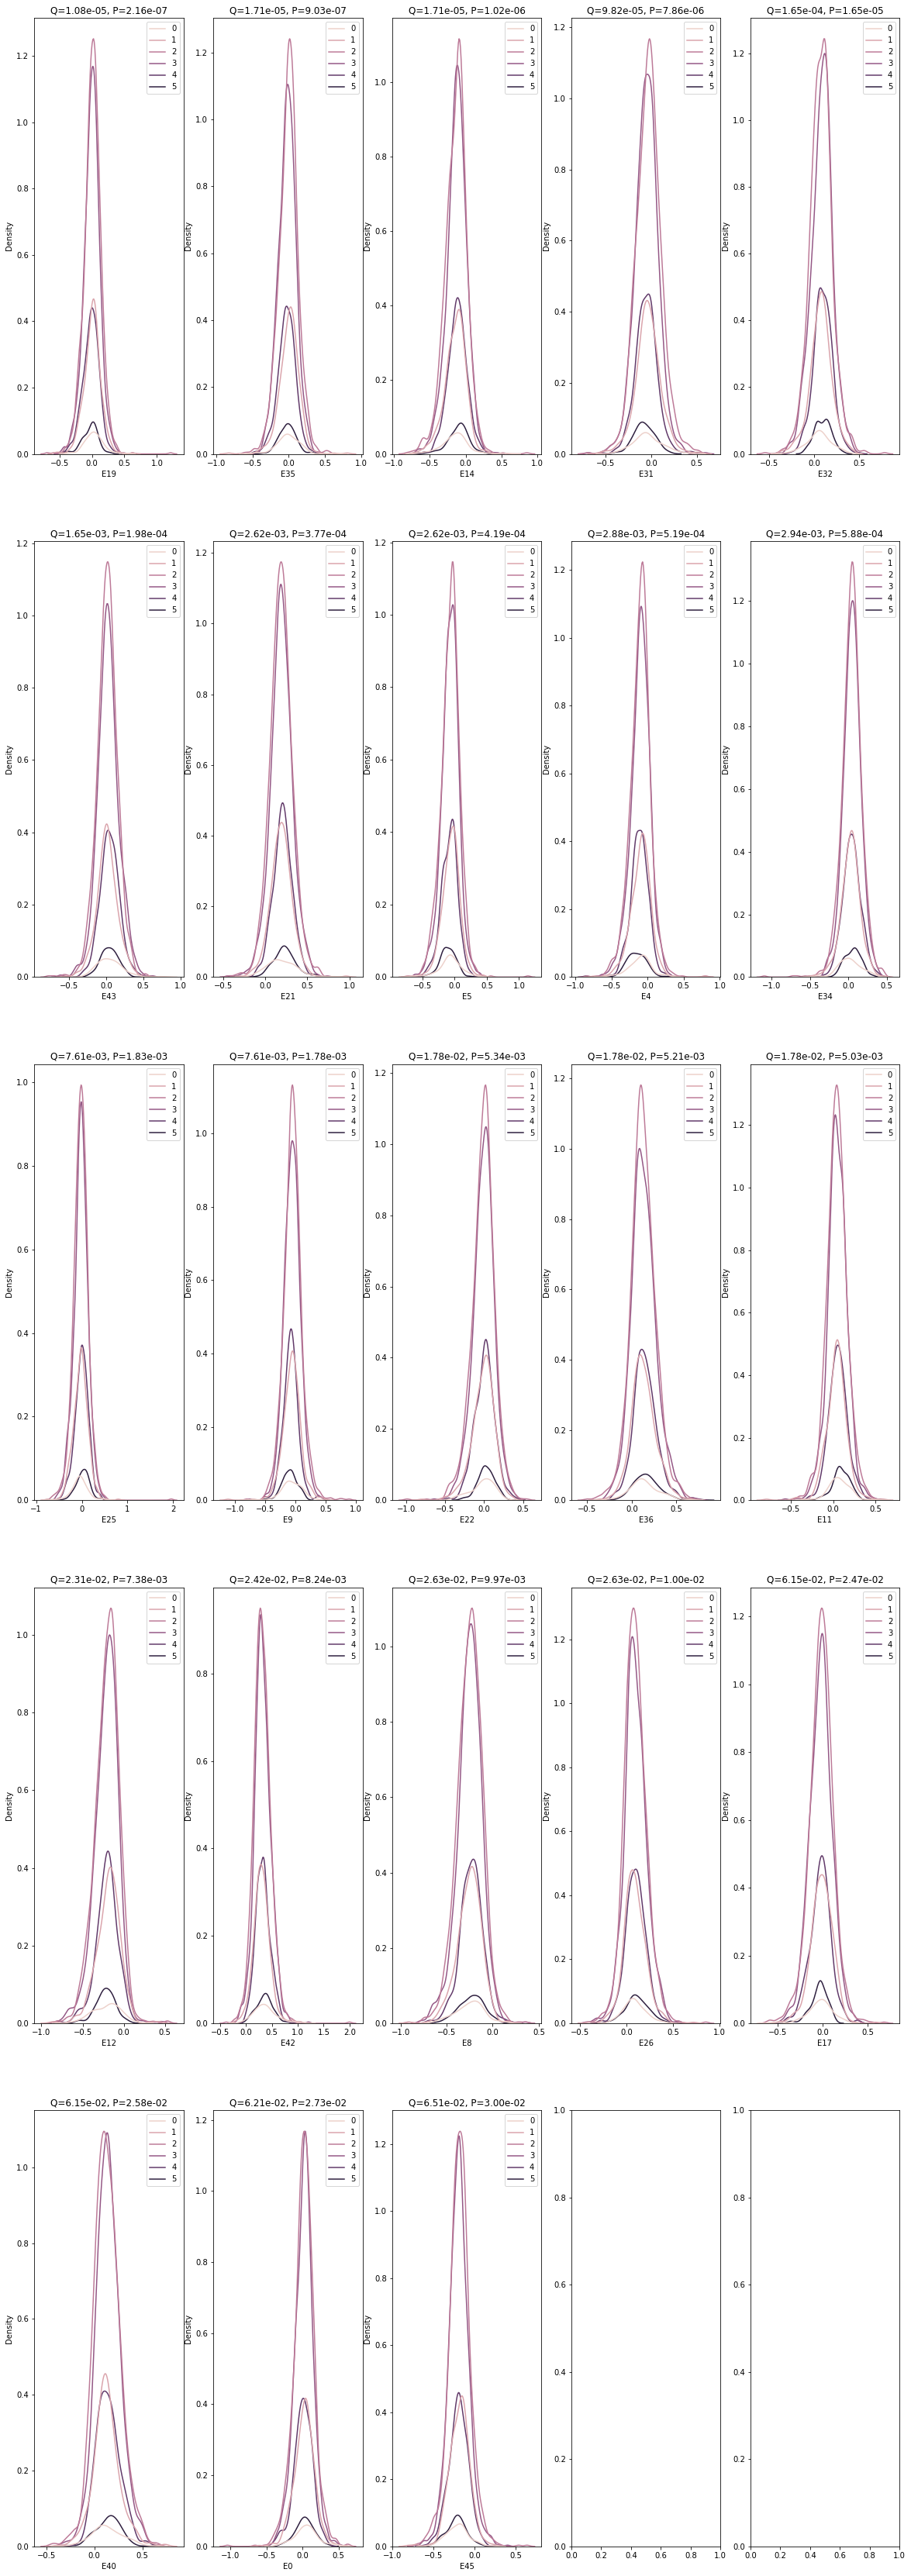

In [240]:
from math import ceil
print("Significant embedding dimensions histograms")
fig, axes = plt.subplots(ceil(numSig/5),5, figsize=(20,60))
axes = np.reshape(axes, axes.size)
for c, col in enumerate(embsDF.columns[order][maskSig[order]]):
    f = sns.kdeplot(x=embsDF[col], hue = groups,ax=axes[c])
    axes[c].set_title(f'Q={qvals[1][order][maskSig[order]][c]:.2e}' f', P={pvals[order][maskSig[order]][c]:.2e}')

In [206]:
lm = LinearRegression().fit(x[:, qvals[0]], y)
lm_preds = lm.predict(x[:, qvals[0]])
r2_score(y, lm_preds)

0.04519124972555266

Text(0, 0.5, 'pred')

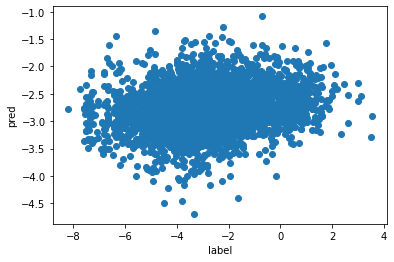

In [207]:
plt.scatter(y, lm_preds)
plt.xlabel("label")
plt.ylabel("pred")

In [208]:
print(np.sum((y - lm_preds)**2))

11802.279079603668


In [209]:
print("Total Variance")
print(np.sum((y - np.mean(y))**2))

Total Variance
12360.882822042902


In [210]:
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(x, y).predict(x)
print("Decision Tree MSE")
print(np.sum((tree_preds - y)**2))

Decision Tree MSE
5650.7852169159505


In [211]:
preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(x,y).predict(x)

In [212]:
print("Random Forest MSE")
print(np.sum((preds - y)**2))

Random Forest MSE
1604.1745435440757


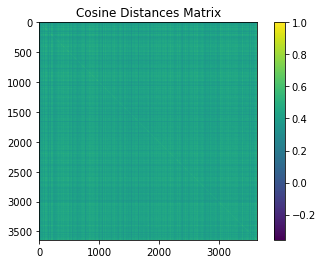

In [213]:
from  sklearn.metrics.pairwise import cosine_similarity

xcos = cosine_similarity(x, x)
plt.imshow(xcos)
plt.title("Cosine Distances Matrix")
plt.colorbar()

In [214]:
# Cosine Distances -> StandardScaler -> PCA ->

cosPcs = PCA(300).fit_transform(StandardScaler().fit_transform(xcos))

Text(0.5, 1.0, 'PCs of GLoVE embeddings Cosine Distances')

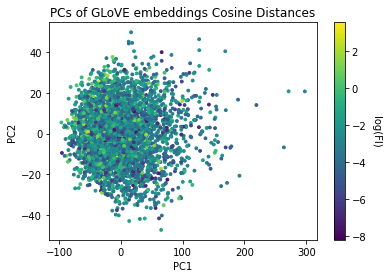

In [215]:
plt.scatter(cosPcs[:, 0], cosPcs[:, 1], c=y, s=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(FI)', rotation=270)
plt.title("PCs of GLoVE embeddings Cosine Distances")

In [216]:
# -> DT

In [217]:
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(pcs, y).predict(pcs)
# import graphviz 
# dot_data = tree.export_graphviz(treeRegressor, filled=True, out_file=None) 
# graph = graphviz.Source(dot_data)
# graph.render("gloveUtrsTree") 
print(np.sum((tree_preds - y)**2))

8934.062111005951


In [218]:
# -> RF
cos_preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(pcs,y).predict(pcs)

In [219]:
print("Random Forest on Cosine PCs MSE")
print(np.sum((cos_preds - y)**2))

Random Forest on Cosine PCs MSE
1956.0781425970972


In [220]:
# Checking Generalization Ability
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.0161
Test data R-2 score: 0.0245
Test data Spearman correlation: 0.164
Test data Pearson correlation: 0.164


Text(0, 0.5, 'Train PR')

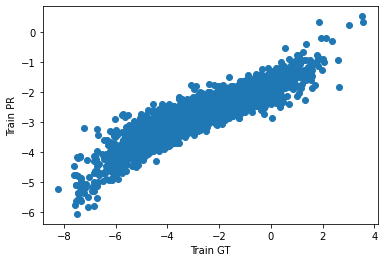

In [221]:
plt.scatter(y_train, predicted_train)
plt.xlabel("Train GT")
plt.ylabel("Train PR")

Text(0, 0.5, 'Test PR')

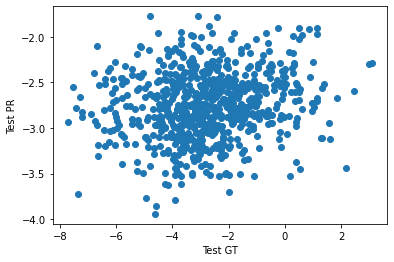

In [222]:
plt.scatter(y_test, predicted_test)
plt.xlabel("Test GT")
plt.ylabel("Test PR")